In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import cv2
from matplotlib import pyplot as plt
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import pandas as pd
import numpy as np
from keras.layers.merge import _Merge
from numpy.random import randn
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, LSTM,Embedding, Conv2D, Dense, \
Conv2DTranspose, Lambda, Input, Concatenate, TimeDistributed, \
MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, Reshape, LeakyReLU
from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow as tf
from keras import backend as k
from keras.applications  import InceptionResNetV2
from keras.optimizers import Adadelta,Adam,RMSprop
from tqdm import tqdm_notebook
from keras.utils import to_categorical
from keras.datasets import cifar10
import keras
from SpectralNormalization import ConvSN2D, DenseSN, ConvSN2DTranspose
from self_attention import Attention
from functools import partial
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.tensorflow_backend.set_session(sess)


Using TensorFlow backend.


In [25]:
def load_real_samples(class_number=0, categorical = False):
    # load dataset
    (trainX, trainy), (testX, testy) = cifar10.load_data()
    if class_number>-1:
        selected_ix = (trainy == class_number)
        selected_ix = np.squeeze(selected_ix)
        trainX = trainX[selected_ix]
        trainy = trainy[selected_ix]
    else:
        pass
    # expand to 3d, e.g. add channels
#     X = np.expand_dims(trainX, axis=-1)
    # convert from ints to floats
    trainX = trainX.astype('float32')
    testX = testX.astype('float32')
#     X = np.expand_dims(X,axis=-1)
    # scale from [0,255] to [-1,1]
    trainX = (trainX-127.5)/127.5
    testX = (testX-127.5)/127.5
    if categorical:
        trainy = to_categorical(trainy)
        testy = to_categorical(testy)
    return trainX, trainy, testX, testy
def generate_real_samples(dataset, conditions, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
#     print(ix)
    # select images
    X = dataset[ix]
    X_cond = conditions[ix]
    # generate class labels, -1 for 'real'
#     y = -np.ones((n_samples, 1))
    return X, X_cond


In [26]:
X, X_cond, T, T_cond = load_real_samples(class_number=-1, categorical=True)

In [27]:
# tg = dataGenerator(mode='train')
# vg = dataGenerator(mode='val')

In [28]:
X.shape, X_cond.shape

((50000, 32, 32, 3), (50000, 10))

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

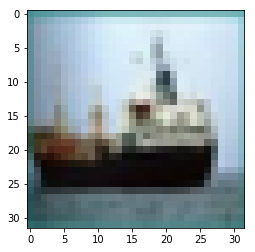

In [30]:
x,c = generate_real_samples(T,T_cond,100)
plt.imshow((x[0]+1)/2)
c[0]

In [24]:
randomDim = 90

# Optimizer Hyperparameters
gen_lr = 0.0001
gen_beta1 = 0.0
gen_beta2 = 0.999

disc_lr = 0.0004
disc_beta1 = 0.0
disc_beta2 = 0.999

# The training ratio is the number of discriminator updates
# per generator update. The paper uses 5.
TRAINING_RATIO = 1
GRADIENT_PENALTY_WEIGHT = 10  # As per the paper

# Iteration Hyperparameters
batch_size = 64
eval_batch_size = 10000
start_iter = 1
max_iters = 300000
eval_iters = 1000
save_evals = 10


In [ ]:

g_opt = Adam(lr=gen_lr, beta_1=gen_beta1, beta_2=gen_beta2)
d_opt = Adam(lr=disc_lr, beta_1=disc_beta1, beta_2=disc_beta2)


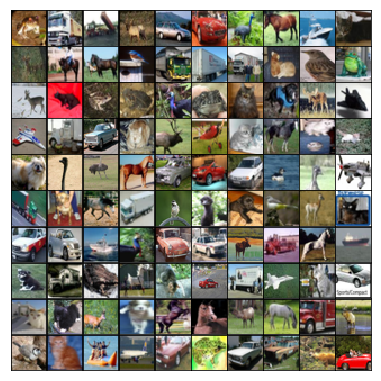

In [8]:

def plot_data(x,ax):
#     x = x.reshape((size,size))
    
    ax.imshow((x+1)/2, cmap='gray')
#     if y is not None:
#         ax.scatter(y[0::2] , y[1::2] , marker='x', s=10)
def plot_images(x,batch_size=100):
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)

    for i in range(batch_size):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    #     print(y['classes'][i])
    #     print(np.argmax(c[i]))
        plot_data(x[i], ax)
plot_images(X)

In [9]:
import keras.backend as K

def hinge_loss(y_true, y_pred):
    return K.mean(K.square(K.maximum(1. - (y_true * y_pred), 0.)), axis=-1)


In [10]:
dLosses = []
gLosses = []
from keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

class RandomWeightedAverage(_Merge):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this
    outputs a random point on the line between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could
    think of. Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((batch_size, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])
    
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('plots/cifar10_cond_hinge_sn_sa_gp/dcgan_%d_loss_epoch.png' % epoch)
    plt.close()

def plotGeneratedImages(epoch, examples=100, dim=(1, 1), figsize=(2, 2)):
    n_classes = 10
    z = np.repeat(np.random.uniform(-1, 1, (10, randomDim)),10,axis=0)
    labels = np.tile(np.eye(n_classes), [10, 1])
#     labels = np.repeat(np.arange(10).reshape(1,-1),10, axis=0).reshape((-1))
    generatedImages = generator.predict([labels, z])
#     print(generatedImages.shape)
#     generatedImages = generatedImages*255.0 + 255.0
#     print(generatedImages.min(),generatedImages.max())
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
    for i in range(examples):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    #     print(y['classes'][i])
        plot_data(generatedImages[i], ax)
    fol = 'generatedimages/cifar10_cond_hinge_sn_sa_gp/'
    if not os.path.exists(fol):
        os.makedirs(fol)
    plt.savefig(fol+'random_{:05d}.png'.format(epoch))
    plt.close()
    
    
def saveModels(epoch):
    fol = 'models/cifar10_cond_hinge_sn_sa_gp/'
    if not os.path.exists(fol):
        os.makedirs(fol)
    generator.save(fol+'dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save(fol+'dcgan_discriminator_epoch_%d.h5' % epoch)
    
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = cv2.resize(image,(new_shape),interpolation=cv2.INTER_LINEAR)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


def gradient_penalty_loss(y_true, y_pred, averaged_samples,
                          gradient_penalty_weight):
    """Calculates the gradient penalty loss for a batch of "averaged" samples.

    In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the
    loss function that penalizes the network if the gradient norm moves away from 1.
    However, it is impossible to evaluate this function at all points in the input
    space. The compromise used in the paper is to choose random points on the lines
    between real and generated samples, and check the gradients at these points. Note
    that it is the gradient w.r.t. the input averaged samples, not the weights of the
    discriminator, that we're penalizing!

    In order to evaluate the gradients, we must first run samples through the generator
    and evaluate the loss. Then we get the gradients of the discriminator w.r.t. the
    input averaged samples. The l2 norm and penalty can then be calculated for this
    gradient.

    Note that this loss function requires the original averaged samples as input, but
    Keras only supports passing y_true and y_pred to loss functions. To get around this,
    we make a partial() of the function with the averaged_samples argument, and use that
    for model training."""
    # first get the gradients:
    #   assuming: - that y_pred has dimensions (batch_size, 1)
    #             - averaged_samples has dimensions (batch_size, nbr_features)
    # gradients afterwards has dimension (batch_size, nbr_features), basically
    # a list of nbr_features-dimensional gradient vectors
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)


In [11]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
model.trainable = False
model.trainable_weights

[]

In [12]:
def build_generator():
    condition = Input(shape=(10,),name='GeneratorCondition')
    noiseInput = Input(shape=(randomDim,),name='GeneratorInput')


    model =  Concatenate()([condition,noiseInput])

#     model = Dense(2*2*1024)(model)
#     model = LeakyReLU(0.1)(model)
    model = Reshape((1, 1, 100))(model)


    model = ConvSN2DTranspose(1024, strides=(2,2), kernel_size=(4, 4), padding='same')(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(0.1)(model)

    model = ConvSN2DTranspose(512, strides=(2,2), kernel_size=(4, 4), padding='same')(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(0.1)(model)

    model = ConvSN2DTranspose(256, strides=(2,2), kernel_size=(4, 4), padding='same')(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(0.1)(model)
    
    
    
    model = ConvSN2DTranspose(256, strides=(2,2), kernel_size=(4, 4), padding='same')(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(0.1)(model)
    
    model, beta, gamma = Attention(256)(model)
    
    model = ConvSN2DTranspose(3, strides=(2,2), kernel_size=(4,4),padding='same',activation='tanh',name='G')(model)
    
    g = Model([condition,noiseInput],model, name='Generator')
    g.summary()
#     display(SVG(model_to_dot(generator,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))
    return g
generator = build_generator()

(1, 1, 256, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GeneratorCondition (InputLayer) (None, 10)           0                                            
__________________________________________________________________________________________________
GeneratorInput (InputLayer)     (None, 90)           0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 100)          0           GeneratorCondition[0][0]         
                                                                 GeneratorInput[0][0]             
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 1, 100)    0           concatenate_3[0][0]         

In [13]:
# Discriminator

def build_discriminator():
    condition = Input(shape=(10,), name='DiscriminatorCondition')
    inpImage = Input(shape=(32,32,3), name = 'DiscriminatorInput')
    



    d_model = ConvSN2D(input_shape=(32,32,3),filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same')(inpImage)
    d_model = BatchNormalization()(d_model)
    d_model = LeakyReLU(0.1)(d_model)
    
    d_model, beta, gamma = Attention(128)(d_model)
    
    d_model = ConvSN2D(512, kernel_size=(4, 4), strides=(2, 2), padding='same')(d_model)
    d_model = BatchNormalization()(d_model)
    d_model = LeakyReLU(0.1)(d_model)
 
    
    
    d_model = ConvSN2D(1024, kernel_size=(4, 4), strides=(2, 2), padding='same')(d_model)
    d_model = BatchNormalization()(d_model)
    d_model = LeakyReLU(0.1)(d_model)


    d_model = ConvSN2D(1024, kernel_size=(4, 4), strides=(2, 2), padding='same')(d_model)
    d_model = BatchNormalization()(d_model)
    d_model = LeakyReLU(0.1)(d_model)


    d_model = Flatten()(d_model)
    d_model = Concatenate()([d_model,condition])
    # d_model = Lambda(lambda x: tf.expand_dims(x,axis=-1))(d_model)
    d_model = Dense(1, activation='linear',name='D')(d_model)

    d = Model( [condition,inpImage], d_model, name='Discriminator')
    d.compile(loss=hinge_loss, optimizer=d_opt, metrics=['accuracy'])
    d.summary()
#     display(SVG(model_to_dot(discriminator,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))
    return d
discriminator = build_discriminator()

(1, 1, 128, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DiscriminatorInput (InputLayer) (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_s_n2d_1 (ConvSN2D)         (None, 16, 16, 128)  6400        DiscriminatorInput[0][0]         
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 16, 16, 128)  512         conv_s_n2d_1[0][0]               
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 16, 16, 128)  0           batch_normalization_99[0][0]     
_____________________________________________________________________________________________

In [14]:
# def gradient_penalty(real, fake, classes):
#     alpha = tf.random_uniform(shape=[self.batch_size, 1, 1, 1], minval=0., maxval=1.)
#     interpolated = alpha*real + (1. - alpha)*fake

#     logit = discriminator([interpolated, classes], reuse=True)

#     grad = tf.gradients(logit, interpolated)[0]  # gradient of D(interpolated)
#     grad_norm = tf.norm(flatten(grad), axis=1)  # l2 norm

#     GP = 0
#     GP = self.ld * tf.reduce_mean(tf.square(grad_norm - 1.))

#     return GP

In [15]:
# discriminator.trainable = False

# g_cond_inp,latent_inp = generator.inputs          
# g =  generator([g_cond_inp,latent_inp])

# # d_cond_inp = Input((10,)) 
# # print(x.shape)
# ganOutput = discriminator([g_cond_inp, g])
                   
# gan = Model(inputs=[g_cond_inp,latent_inp], outputs=ganOutput, name='GAN')
# # gan.layers[1].name = "Generator_Network"
# # gan.layers[2].name = "Discriminator_Network"
# gan.compile(loss=hinge_loss, optimizer=g_opt, metrics=['accuracy'])
# gan.summary()

# display(SVG(model_to_dot(model=gan,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))

In [16]:
# The generator_model is used when we want to train the generator layers.
# As such, we ensure that the discriminator layers are not trainable.
# Note that once we compile this model, updating .trainable will have no effect within
# it. As such, it won't cause problems if we later set discriminator.trainable = True
# for the discriminator_model, as long as we compile the generator_model first.
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False
generator_input = Input(shape=(90,),name='generator_input')
generator_cond = Input(shape=(10,),name='generator_cond')
discriminator_cond = Input(shape=(10,),name='discriminator_cond')
generator_layers = generator([generator_cond, generator_input])
discriminator_layers_for_generator = discriminator([discriminator_cond,generator_layers])
generator_model = Model(inputs=[discriminator_cond,generator_cond, generator_input],
                        outputs=[discriminator_layers_for_generator])
# We use the Adam paramaters from Gulrajani et al.
generator_model.compile(optimizer=g_opt,
                        loss=hinge_loss)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_cond (InputLayer)     (None, 10)           0                                            
__________________________________________________________________________________________________
generator_input (InputLayer)    (None, 90)           0                                            
__________________________________________________________________________________________________
discriminator_cond (InputLayer) (None, 10)           0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 32, 32, 3)    13279656    generator_cond[0][0]             
                                                                 generator_input[0][0]            
__________

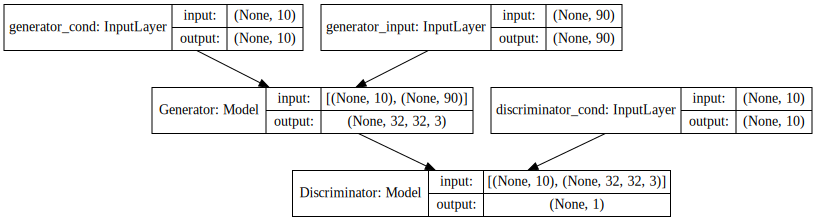

In [17]:

generator_model.summary()
display(SVG(model_to_dot(model=generator_model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))


In [18]:
# Now that the generator_model is compiled, we can make the discriminator
# layers trainable.
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

# The discriminator_model is more complex. It takes both real image samples and random
# noise seeds as input. The noise seed is run through the generator model to get
# generated images. Both real and generated images are then run through the
# discriminator. Although we could concatenate the real and generated images into a
# single tensor, we don't (see model compilation for why).
real_samples = Input(shape=(32,32,3),name='real_samples')
generator_input_for_discriminator = Input(shape=(90,),name='generator_input_for_discriminator')
generator_cond_for_discriminator = Input(shape=(10,),name='generator_cond_for_discriminator')
discriminator_cond_for_discriminator = Input(shape=(10,), name = 'discriminator_cond_for_discriminator')

generated_samples_for_discriminator = generator([generator_cond_for_discriminator,generator_input_for_discriminator])
discriminator_output_from_generator = discriminator([discriminator_cond_for_discriminator,generated_samples_for_discriminator])
discriminator_output_from_real_samples = discriminator([discriminator_cond_for_discriminator,real_samples])

# We also need to generate weighted-averages of real and generated samples,
# to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples,
                                            generated_samples_for_discriminator])
# We then run these samples through the discriminator as well. Note that we never
# really use the discriminator output for these samples - we're only running them to
# get the gradient norm for the gradient penalty loss.
averaged_samples_out = discriminator([discriminator_cond_for_discriminator,averaged_samples])

# The gradient penalty loss function requires the input averaged samples to get
# gradients. However, Keras loss functions can only have two arguments, y_true and
# y_pred. We get around this by making a partial() of the function with the averaged
# samples here.
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
# Functions need names or Keras will throw an error
partial_gp_loss.__name__ = 'gradient_penalty'

# Keras requires that inputs and outputs have the same number of samples. This is why
# we didn't concatenate the real samples and generated samples before passing them to
# the discriminator: If we had, it would create an output with 2 * BATCH_SIZE samples,
# while the output of the "averaged" samples for gradient penalty
# would have only BATCH_SIZE samples.

# If we don't concatenate the real and generated samples, however, we get three
# outputs: One of the generated samples, one of the real samples, and one of the
# averaged samples, all of size BATCH_SIZE. This works neatly!
discriminator_model = Model(inputs=[generator_cond_for_discriminator \
                                    ,discriminator_cond_for_discriminator \
                                    ,real_samples \
                                    ,generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples \
                                     ,discriminator_output_from_generator \
                                     ,averaged_samples_out])
# We use the Adam paramaters from Gulrajani et al. We use the Wasserstein loss for both
# the real and generated samples, and the gradient penalty loss for the averaged samples
discriminator_model.compile(optimizer=d_opt,
                            loss=[hinge_loss,
                                  hinge_loss,
                                  partial_gp_loss])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_cond_for_discriminato (None, 10)           0                                            
__________________________________________________________________________________________________
generator_input_for_discriminat (None, 90)           0                                            
__________________________________________________________________________________________________
real_samples (InputLayer)       (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 32, 32, 3)    13279656    generator_cond_for_discriminator[
                                                                 generator_input_for_discriminator
__________

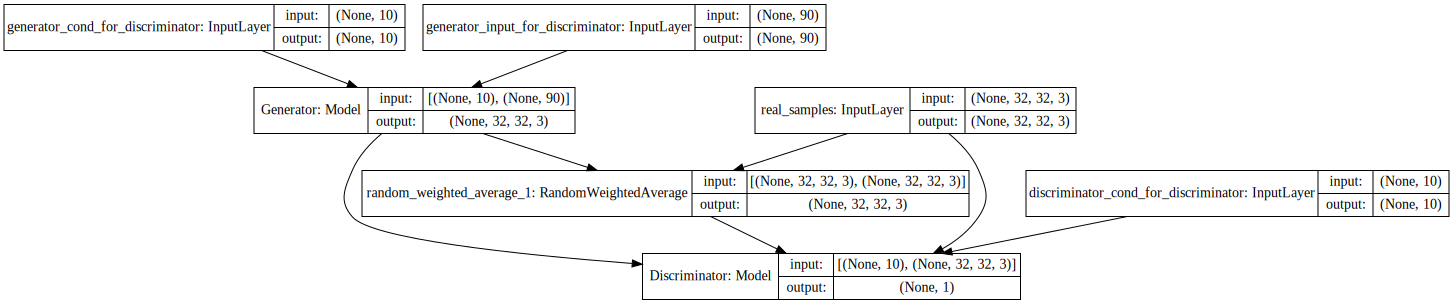

In [19]:
discriminator_model.summary()
display(SVG(model_to_dot(model=discriminator_model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))

In [20]:
tensorboard = TensorBoard(
  log_dir='log/cifar10_cond_hinge_sn_sa_gp',
  histogram_freq=0,
  batch_size=32,
  write_graph=True,
  write_grads=True,
)
tensorboard.set_model(generator_model)

In [21]:
# generator.load_weights('models/cifar10_cond_hinge_sn_sa_gp/dcgan_generator_epoch_15000.h5')
# discriminator.load_weights('models/cifar10_cond_hinge_sn_sa_gp/dcgan_discriminator_epoch_15000.h5')

In [31]:
def train(initepoch=1,epochs=1, batch_size=128, steps = 10):
    print ('Epochs:', epochs)
    print ('Batch size:', batch_size)
    print ('steps per epoch:',steps)
    fids = []
    fid = 0.0
    prev_fid = 100000
    counter = 0
    real_labels = np.ones((batch_size,1),dtype=np.float32)
    fake_labels = -np.ones((batch_size,1),dtype=np.float32)
    dummy_labels = np.zeros((batch_size, 1), dtype=np.float32)
    for e in tqdm_notebook(range(initepoch, epochs+1)):
#         for step in range(steps):
            # Get a random set of input noise and images
        
        for l in discriminator.layers: l.trainable = True
        discriminator.trainable = True
        
        for l in generator.layers: l.trainable = False
        generator.trainable = False
        for i in range(TRAINING_RATIO):
            z = np.random.uniform(-1, 1, (batch_size, randomDim))
            imageBatch, conds = generate_real_samples(dataset=X,conditions=X_cond, n_samples=batch_size)

#             generatedImages = generator.predict([conds, z])

            d_loss = discriminator_model.train_on_batch([conds, conds, imageBatch, z], [real_labels, fake_labels, dummy_labels])
#             d_real = discriminator.train_on_batch([conds, imageBatch], real_labels)

#                 #Clip discriminator weights
#             for l in discriminator.layers:
#                 weights = l.get_weights()
#                 weights = [np.clip(w, -0.01,0.01) for w in weights] 
#                 l.set_weights(weights)

#             print(dloss)
        # Train generator
        _, conds = generate_real_samples(dataset=X,conditions=X_cond, n_samples=batch_size)
        z = np.random.uniform(-1, 1, (batch_size, randomDim))

        for l in discriminator.layers: l.trainable = False
        discriminator.trainable = False
        
        
        for l in generator.layers: l.trainable = True
        generator.trainable = True
        
        ganloss = generator_model.train_on_batch([conds, conds, z], real_labels)
        
        # Store loss of most recent batch from this epoch
#         dLosses.append(dloss)
#         gLosses.append(gloss)
        if e == 1 or e % 1000 == 0:
            
#             test_range = np.arange(0, T.shape[0])
#             fids = []
#             gi = 0
#             while gi < T.shape[0]:
            z = np.random.uniform(-1, 1, (eval_batch_size, randomDim))
#             idxs = test_range[gi:gi+eval_batch_size]
#             r_images, r_conds = get_real_samples(T,T_cond,idxs)
            g_images = generator.predict([T_cond, z])
            r_images = scale_images(T, (299,299))
            g_images = scale_images(g_images, (299,299))
            fid = calculate_fid(model,r_images,g_images)
            
            tensorboard.on_epoch_end(e, {
                                        "fid":fid \
                                         ,"d_loss_0":d_loss[0] \
                                         ,"d_loss_1":d_loss[1] \
                                         ,"d_loss_2":d_loss[2] \
                                         ,"d_loss_3":d_loss[3] \
#                                          ,"D_fake_acc":d_fake[1]
#                                          ,"D_fake_loss":d_fake[0]
#                                          ,"GAN_acc":ganloss[1]
                                         ,"gan_loss":ganloss})
            plotGeneratedImages(e)
            if prev_fid>fid:
                saveModels(e)
                prev_fid = fid
        else:
            fid-=0.001
            tensorboard.on_epoch_end(e, {
                                        "fid":fid \
                                         ,"d_loss_0":d_loss[0] \
                                         ,"d_loss_1":d_loss[1] \
                                         ,"d_loss_2":d_loss[2] \
                                         ,"d_loss_3":d_loss[3] \
#                                          ,"D_fake_acc":d_fake[1]
#                                          ,"D_fake_loss":d_fake[0]
#                                          ,"GAN_acc":ganloss[1]
                                         ,"gan_loss":ganloss})

    return np.asarray(fids)

In [32]:
fids = train(initepoch=68000, epochs=300000, batch_size=batch_size, steps=1)

Epochs: 300000
Batch size: 64
steps per epoch: 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [ ]:
# noise = randn(randomDim*batchSize)
# noise = noise.reshape((batchSize,randomDim))
# imageBatch , conds= generate_real_samples(dataset=X, conditions=X_cond,n_samples=64)
# imagesCount = 64
# generatorModel.load_weights('models/cifar10_cond_hingegan_sn_wt_clip/dcgan_generator_epoch_353000.h5')
# images2 = generatorModel.predict([conds,noise])
# images1 = scale_images(images1, (140,140))
# images2 = scale_images(images2, (140,140))
# fid = calculate_fid(model, images1, images2)
d_m = Model(discriminator.inputs,discriminator.get_layer(index=6).output)
d_m.summary()
# g_m = Model(generatorModel.inputs,generatorModel.get_layer(index=-2).output)
# g_m.summary()


In [ ]:
# for l in discriminator.layers:
#     weights = l.get_weights()
#     weights = [np.clip(w, -0.01,0.01) for w in weights] 
#     l.set_weights(weights)
# for l in discriminator.layers:
    
#     weights = l.get_weights()
#     print(weights)
#     print(l.name,':',np.shape(weights))

In [ ]:
# for w in discriminator.layers[4].get_weights():
#     print(np.min(w),np.max(w))

In [ ]:
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# DiscriminatorInput (InputLayer) (None, 32, 32, 3)    0                                            
# __________________________________________________________________________________________________
# conv_s_n2d_1 (ConvSN2D)         (None, 16, 16, 256)  12800       DiscriminatorInput[0][0]         
# __________________________________________________________________________________________________
# batch_normalization_5 (BatchNor (None, 16, 16, 256)  1024        conv_s_n2d_1[0][0]               
# __________________________________________________________________________________________________
# leaky_re_lu_5 (LeakyReLU)       (None, 16, 16, 256)  0           batch_normalization_5[0][0]      
# __________________________________________________________________________________________________
# attention_2 (Attention)         [(None, 16, 16, 256) 82241       leaky_re_lu_5[0][0]              
# __________________________________________________________________________________________________
# conv_s_n2d_2 (ConvSN2D)         (None, 8, 8, 512)    2098176     attention_2[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_6 (BatchNor (None, 8, 8, 512)    2048        conv_s_n2d_2[0][0]               
# __________________________________________________________________________________________________
# leaky_re_lu_6 (LeakyReLU)       (None, 8, 8, 512)    0           batch_normalization_6[0][0]      
# __________________________________________________________________________________________________
# conv_s_n2d_3 (ConvSN2D)         (None, 4, 4, 1024)   8390656     leaky_re_lu_6[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_7 (BatchNor (None, 4, 4, 1024)   4096        conv_s_n2d_3[0][0]               
# __________________________________________________________________________________________________
# leaky_re_lu_7 (LeakyReLU)       (None, 4, 4, 1024)   0           batch_normalization_7[0][0]      
# __________________________________________________________________________________________________
# conv_s_n2d_4 (ConvSN2D)         (None, 2, 2, 1024)   16779264    leaky_re_lu_7[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_8 (BatchNor (None, 2, 2, 1024)   4096        conv_s_n2d_4[0][0]               
# __________________________________________________________________________________________________
# leaky_re_lu_8 (LeakyReLU)       (None, 2, 2, 1024)   0           batch_normalization_8[0][0]      
# __________________________________________________________________________________________________
# flatten_1 (Flatten)             (None, 4096)         0           leaky_re_lu_8[0][0]              
# __________________________________________________________________________________________________
# DiscriminatorCondition (InputLa (None, 10)           0                                            
# __________________________________________________________________________________________________
# concatenate_2 (Concatenate)     (None, 4106)         0           flatten_1[0][0]                  
#                                                                  DiscriminatorCondition[0][0]     
# __________________________________________________________________________________________________
# D (Dense)                       (None, 1)            4107        concatenate_2[0][0]              
# ==================================================================================================
# Total params: 27,378,508
# Trainable params: 27,370,060
# Non-trainable params: 8,448

In [ ]:
z = np.random.uniform(-1, 1, (100, randomDim))
f_conds = to_categorical(np.zeros(100)+9,num_classes=10)
generatedImages = generator.predict([f_conds,z])


realImages, conds = generate_real_samples(dataset=X,conditions=X_cond, n_samples=100)
df, da, dsma, dg = d_m.predict([f_conds,generatedImages])
# gf, ga, gsma, gg = g_m.predict([f_conds,z])

In [ ]:
plot_images(generatedImages)

In [ ]:
dg.min(),dg.max()

In [ ]:
np.unique(gg).shape


In [ ]:
pd.DataFrame(fids)

In [ ]:
_, conds = generate_real_samples(dataset=X,conditions=X_cond, n_samples=batch_size)
for i in range(10):
    print(np.argmax(conds[i]))
    plt.imshow(_[i])
    plt.show()

In [ ]:
np.repeat(a=np.arange(10).reshape(1,-1),repeats=10, axis=0).reshape((-1))

In [ ]:
np.arange(10).reshape(1,-1)

In [ ]:
# https://arxiv.org/pdf/1611.06355.pdf - invertible
# https://arxiv.org/pdf/1411.1784.pdf - cGANs
# https://arxiv.org/pdf/1802.05957.pdf - SN GANs
# https://www.quora.com/How-does-Conditional-Batch-normalization-work-and-how-is-it-different-from-regular-Batch-normalization

In [ ]:
imagesCount = 100
z = np.repeat(np.random.uniform(-1, 1, (10, randomDim)),10,axis=0)
labels = np.tile(np.eye(10), [10, 1])
#             labels = np.repeat(a=np.arange(10).reshape(1,-1),repeats=10, axis=0).reshape((-1))
images1, _ = generate_real_samples(dataset=X,conditions=X_cond,n_samples=imagesCount) # Here X is test data of CIFAR10
images2 = generator.predict([labels, z])
images1 = scale_images(images1, (140,140))
images2 = scale_images(images2, (140,140))
# fid = calculate_fid(model, images1, images2)
# fids.append(fid)

In [ ]:
images1.min(),images1.max()

In [ ]:
images2.min(),images2.max()

In [ ]:
from PIL import Image
def tile_images(image_stack):
    """Given a stacked tensor of images, reshapes them into a horizontal tiling for
    display."""
    print(image_stack.shape)
    assert len(image_stack.shape) == 4
    image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
    print(np.shape(image_list))
    image_list = np.concatenate(image_list, axis=1)
    print(image_list.shape)
    return image_list
def generate_images(generator_model):
    """Feeds random seeds into the generator and tiles and saves the output to a PNG
    file."""
    test_image_stack = generator_model.predict([np.tile(np.eye(10),reps=[10,1]),np.repeat(np.random.uniform(low=-1,high=1,size=(10, 90)),repeats=10,axis=0)])
    test_image_stack = (test_image_stack * 127.5) + 127.5
#     test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
    tiled_output = tile_images(test_image_stack)
    print(tiled_output.shape)
    tiled_output = plt.imshow(tiled_output) # L specifies greyscale
    display(tiled_output)
#     outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
#     tiled_output.save(outfile)

In [ ]:
generate_images(generator)

In [ ]:
np.tile(np.eye(10),reps=[10,1])

In [33]:
saveModels(300000)